## Try Boosting

# 1. xgboost

In [1]:
# import data, N(number of observation), N_f(number of features) & functions features
from _data import *

/Users/kimdom/Documents/project/E-Sun_CC_Fraud_detection/_data.py:35: RuntimeWarning: divide by zero encountered in true_divide
  ratio = list(map(lambda x: 0 if x == np.Inf else x,(para_f[0]/para_nf[0])))+[0]
/Users/kimdom/Documents/project/E-Sun_CC_Fraud_detection/_data.py:35: RuntimeWarning: invalid value encountered in true_divide
  ratio = list(map(lambda x: 0 if x == np.Inf else x,(para_f[0]/para_nf[0])))+[0]


In [2]:
%matplotlib inline
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
#from lib import XGBHelper as xgbh

In [3]:
def model_evl(pred, label):
    if len(pred)!=len(label):
        raise Exception('length not equal, plz chk, pred:%s, label: %s'%(len(pred), len(label)))
    evl = {}
    if sorted(np.unique(pred)) == [-1,1]:
        pred[pred==-1]=0
    a = pd.concat([pd.Series(pred, name='pred'), pd.Series(label, name='label')],axis=1)
    #evl['ACC'] = sum(a['pred']==a['fraud_ind'])/len(pred) # accuracy
    evl['TP'] = sum((a['pred']<0.5) & (a['label'] ==0))
    evl['TN'] = sum((a['pred']>=0.5) & (a['label'] ==1))
    evl['MS'] = sum((a['pred']>0.5) & (a['label'] ==1))
    evl['FA'] = sum((a['pred']>=0.5) & (a['label'] ==0))
    evl['ACC'] = (evl['TP']+evl['TN'])/len(pred)
    return evl

def cal_f1(evl):
    precision = evl['TN']/(evl['TN']+evl['FA'])
    recall = evl['TN']/(evl['TN']+evl['MS'])
    F_1 = 2*(precision*recall/(precision+recall))
    return F_1

In [40]:
%%time
import json
with open("feature_map.json",encoding='utf-8') as json_data:
     f_m = json.load(json_data)

CPU times: user 360 ms, sys: 246 ms, total: 606 ms
Wall time: 819 ms


In [5]:
train_raw_cvt = pd.concat([
        trans_obj(train_raw), \
        txn_amt_prob(train_raw),\ 
        to_timeseg(train_raw)[0],\
        to_timeseg(train_raw)[1],\
        stocn_cvt(train_raw).drop('stocn',axis=1)], axis=1)

In [6]:
train_x = train_raw_cvt.drop(['fraud_ind','txkey'],axis=1)
train_y = train_raw_cvt['fraud_ind']


- Training: 70%
- Validation: 15%
- Testing: 15%

In [9]:
def set_parm(max_depth=3, eta=0.3, silent=0, objective ='binary:logistic', nthread = 7, eval_metrics = 'logloss'):
    param={}
    param['max_depth']=  max_depth  # depth of tree
    param['eta'] = eta     # shrinkage parameter
    param['silent'] = silent    # not silent
    param['objective'] = objective
    param['nthread'] = nthread # Number of threads used
    param['eval_metric'] = eval_metrics
    print(param)
    return param.items()
# plst = set_parm()

In [10]:
def run_model(train_x, train_y, num_round = 1000, plst=set_parm()):
    
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.30)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    evallist = [(dtrain, 'train'), (dval, 'eval'), (dtest, 'test')]
    # bst1000 is model with 1000 iterations
    # Use early_stopping_rounds=5 to enable early stopping
    bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False, early_stopping_rounds=50)
    val_preds = bst.predict(dval, ntree_limit=bst.best_ntree_limit)
    test_preds = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
    val_labels = dval.get_label()
    test_labels = dtest.get_label()
    val_f1 = cal_f1(model_evl(val_preds, val_labels))
    test_f1 = cal_f1(model_evl(test_preds, test_labels))
    return bst, val_f1, test_f1

{'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}


In [11]:
datetime = !date +%Y%m%d-%H%M
dir_name = 'model_'+datetime[0]
!mkdir $dir_name

In [13]:

plst = set_parm()

train_x, val_f1, test_f1 = run_model(train_x,train_y, plst = plst)
#model_log['model_para'] = plst
#model_log['perfomance'] = {'val':val_f1,'test':test_f1}
bst.save_model('%s/model_new_featue.model'%dir_name)

{'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [ ]:
print(val_f1, test_f1)

In [23]:
etas = [0.1, 0.15, 0.2]
num_rounds = [800, 900, 1000, 1100, 1200]
run_set = []
for i in etas:
    for j in num_rounds:
        if j > 1000 and i in [0.1, 0.15, 0.2]:
            run_set.append((i,j))
        elif j ==1000:
            run_set.append((i,j))
        elif j<1000 and i in [0.25,0.3, 0.35]:
            run_set.append((i,j))

In [24]:
run_set

[(0.1, 1000),
 (0.1, 1100),
 (0.1, 1200),
 (0.15, 1000),
 (0.15, 1100),
 (0.15, 1200),
 (0.2, 1000),
 (0.2, 1100),
 (0.2, 1200),
 (0.25, 800),
 (0.25, 900),
 (0.25, 1000),
 (0.3, 800),
 (0.3, 900),
 (0.3, 1000),
 (0.35, 800),
 (0.35, 900),
 (0.35, 1000)]

In [25]:
track = []
for r_s in run_set[13:-1]:
    nr = r_s[1]
    eta = r_s[0]
    plst = set_parm(eta = eta)
    bst, val_f1,test_f1 = run_model(train_x,train_y,num_round = nr, plst = plst)
    print(r_s, val_f1,test_f1)
    track.append(('models/%s_%s.model'%r_s, val_f1, test_f1))
    bst.save_model('models/%s_%s.model'%r_s)
    

{'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.3, 900) 0.6239756051076807 0.6256635548233571
{'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.3, 1000) 0.6256120527306968 0.6258601955813111
{'max_depth': 3, 'eta': 0.35, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.35, 800) 0.624286258089075 0.6263177026535804
{'max_depth': 3, 'eta': 0.35, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.35, 900) 0.6279287722586692 0.6276195593766792


In [133]:
track                                                                 

[('models/0.1_800.model', 0.6223394236202675, 0.6260463305431185)]

# select feature with xgboost feature importance 

In [15]:
model = XGBClassifier(learning_rate = 0.1, n_estimators=600, max_depth=3)
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [39]:
pd.DataFrame(model.feature_importances_, train_x.columns).sort_values(0)


,0
loctm_cvt,0.000000
stscd_4,0.000000
stscd_3,0.000000
stscd_0,0.000000
iterm,0.002656
contp,0.003326
insfg,0.003664
locdt_cvt,0.004248
loctm,0.006997
ovrlt,0.007892


In [44]:
y_pred = model.predict(X_test)

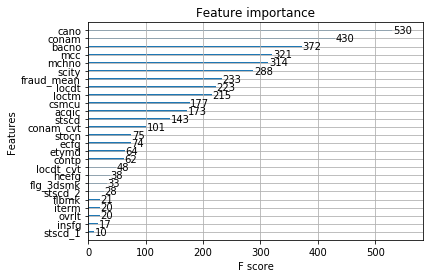

In [35]:
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [46]:
 not_important = ['hcefg', 'insfg', 'iterm', 'flg_3dsmk', 'flbmk', 'contp', 'ovrlt']

In [57]:
train_x2 = train_x.drop(not_important,axis=1)

In [58]:
track2 = []
for r_s in run_set[0:-1]:
    nr = r_s[1]
    eta = r_s[0]
    plst = set_parm(eta = eta)
    bst2, val_f12,test_f12 = run_model(train_x2,train_y,num_round = nr, plst = plst)
    print(r_s, val_f12,test_f12)
    track2.append(('models_2/%s_%s.model'%r_s, val_f12, test_f12))
    bst2.save_model('models_2/%s_%s.model'%r_s)

{'max_depth': 3, 'eta': 0.1, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(0.1, 1000) 0.6177908113391984 0.6132887189292542
{'max_depth': 3, 'eta': 0.1, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.1, 1100) 0.6125390343502282 0.6136309665162669
{'max_depth': 3, 'eta': 0.1, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.1, 1200) 0.6215253029223093 0.6146811070998798
{'max_depth': 3, 'eta': 0.15, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.15, 1000) 0.6233586731167934 0.6211261457878655
{'max_depth': 3, 'eta': 0.15, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.15, 1100) 0.6217472118959109 0.6223835967535242
{'max_depth': 3, 'eta': 0.15, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.15, 1200) 0.617732884399551 0.6236070047759836
{'max_depth': 3, 'eta': 0.2, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}
(0.2, 1000)

# with MCA

In [29]:
mca = pd.read_csv('train_mca_out.csv')

In [30]:
exclude = ['bacno', 'txkey','locdt','loctm', 'cano','conam','mchno','acqic','scity','fraud_ind','mcc']
data_mca_deduct = train_raw[exclude].drop(['fraud_ind','txkey'],axis=1)
train_y = train_raw['fraud_ind']

In [6]:
param={}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['silent'] = 0     # not silent
param['objective'] = 'binary:logistic'
param['nthread'] = 7 # Number of threads used
param['eval_metric'] = 'logloss'

plst = param.items()
print(param)

# bst1000 is model with 1000 iterations
num_round = 1000

{'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': 'logloss'}


In [61]:
track={}
for i in [2]:
    print(list(str(j) for j in range(i)))
    mac_incldue = mca[list(str(j) for j in range(i))]
    data_mca_deduct_2 =pd.concat([data_mca_deduct, mac_incldue],axis=1)
    train_x = data_mca_deduct_2
    
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.30)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label =y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    evallist = [(dtrain, 'train'), (dval, 'eval'),(dtest, 'test')]
    
    # Use early_stopping_rounds=5 to enable early stopping
    bst1000 = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False,early_stopping_rounds=10)
    
    preds_eval = bst1000.predict(dval)
    preds_test = bst1000.predict(dtest)
    
    labels_eval = dval.get_label()
    labels_test = dtest.get_label()
    
    a = cal_f1(model_evl(preds_eval, labels_eval))
    b = cal_f1(model_evl(preds_test, labels_test))
    
    #track[str(i)] = {"F1": {"eval":a, "test":b}}

['0', '1']


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [35]:
track

{'2': {'F1': {'eval': 0.6286158027567462, 'test': 0.6312368571974766}},
 '3': {'F1': {'eval': 0.622634508348794, 'test': 0.6235755651036802}},
 '4': {'F1': {'eval': 0.6287282708142726, 'test': 0.630671166104237}},
 '5': {'F1': {'eval': 0.6258868648130393, 'test': 0.6298502075437648}},
 '6': {'F1': {'eval': 0.6277643560676454, 'test': 0.6245480494766888}}}

In [34]:
#bst1000.save_model('n1000_mca0_8.model')

In [70]:
rTest = pd.read_csv('test.csv')


exclude = ['bacno', 'txkey','locdt','loctm', 'cano','conam','mchno','acqic','scity','mcc']

rTest_X = rTest[exclude].drop('txkey',axis=1)

rTest_mca = pd.read_csv('test_mca_out.csv')

In [71]:
rTest_X2 = pd.concat([rTest_X, rTest_mca[['0','1']]], axis=1)
rTest_X2.head()

,bacno,locdt,loctm,cano,conam,mchno,acqic,scity,mcc,0,1
0,163188,102,215328.0,116799,513.8,59360,6881,0,457,-0.093944,-0.587198
1,163188,102,222007.0,116799,513.8,59360,6881,0,457,-0.093944,-0.587198
2,163188,100,170013.0,116799,513.8,59360,6881,0,457,-0.093944,-0.587198
3,163188,100,165914.0,116799,513.8,59360,6881,0,457,-0.093944,-0.587198
4,163188,102,215311.0,116799,513.8,59360,6881,0,457,-0.093944,-0.587198


In [73]:
a=xgb.DMatrix(rTest_X2)
b = pd.DataFrame(bst1000.predict(a))

In [85]:
ans = pd.DataFrame()
ans['txkey'] = rTest['txkey']
ans['fraud_ind'] =(b[0]>=0.5).astype('int')

In [88]:
ans.to_csv('result_1.csv')

In [75]:
pd.read_csv('submission_test.csv')

,txkey,fraud_ind
0,592489,0
1,592452,0
2,590212,0
3,590209,0
4,592488,0
...,...,...
421660,1187507,0
421661,1182598,0
421662,898724,0
421663,971467,0


In [65]:
X_train

,bacno,locdt,loctm,cano,conam,mchno,acqic,scity,mcc,0,1
969356,117197,3,214719.0,196204,205.78,55807,3221,6580,288,0.064410,1.263980
605537,98573,38,123130.0,26897,1061.92,60275,6716,5803,247,-0.083417,-0.200314
587809,33759,87,202421.0,192930,490.68,78362,6032,5817,291,-0.086315,-0.219788
284094,75755,46,203346.0,138226,393.39,62101,6716,5803,306,-0.086315,-0.219788
380450,44117,23,153521.0,128943,622.19,986,6850,5817,255,-0.086315,-0.219788
...,...,...,...,...,...,...,...,...,...,...,...
299499,119983,39,173320.0,142285,254.99,54238,3348,6580,380,0.076071,0.795334
1348810,28311,36,132834.0,48337,365.84,44859,6203,379,247,0.051073,1.426497
104296,97459,6,203056.0,129967,318.82,73528,6716,3647,349,-0.083417,-0.200314
384088,129456,45,194012.0,184447,108.65,34722,6716,5820,257,-0.086315,-0.219788
